## Data Preparation

The BraTS 2024 Adult Post-Treatment Glioma dataset contains \(N=1350\) samples, with 50 reserved here for validation. Each training example consists of four modalities (t1c, t1n, t2f, and t2w) and a mask annotated by expert radiologists. The mask includes the following labels:

- **0**: Background  
- **1**: Non-enhancing tumor core  
- **2**: Surrounding non-enhancing FLAIR hyperintensity  
- **3**: Enhancing tumor  
- **4**: Resection cavity  

To align the dataset with the diffusion pipeline, an additional label for the "head" is introduced. This is done by incrementing each non-background label by 1, followed by using Otsu thresholding from scikit-image to detect the head region, which is assigned label 1. As a result, the final anatomical masks have **six** channels (see the figure below). Adding the head region accelerates the model's learning of head generation. 

Next, all samples are linearly normalized to $[0,1]$ for consistency, as the original BraTS volumes have varying intensity ranges. Finally, volumes are padded and cropped from $(182, 218, 182) → (192, 192, 144)$ to ensure compatibility with the **3D U-Net** used in the diffusion routine. This ensures that dimensions remain multiples of 16, preventing non-integer values during downsampling.

After reviewing the dataset, **68 samples** with artifacts (holes in the head mask) were removed, leading to a final dataset size of $(train, val) = (1235, 48)$.

![Anatomical mask before and after head addition alongside its corresponding T1n volume](../figures/head%20region.png)

In [ ]:
!pip install numpy nibabel scikit-learn scikit-image scipy tqdm
import os
import glob
import numpy as np
import nibabel as nib
from collections import defaultdict
from scipy.ndimage import binary_fill_holes, binary_closing, label
from skimage import measure
from skimage.filters import threshold_otsu
from skimage.morphology import ball
from skimage.transform import resize
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import random
import logging
import yaml

# Load configuration from YAML
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(levelname)s] %(asctime)s - %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define constants from YAML configuration
NEW_LABEL   = config["preprocessing"]["new_label"]
NUM_WORKERS = config["training"]["num_workers"]
TARGET_SHAPE = tuple(config["preprocessing"]["target_shape"])
LABEL_RANGE = tuple(config["preprocessing"]["original_label_range"])

def count_labels_in_seg_masks(seg_dir, label_range=(0, 5)):
    """
    Counts the occurrences of each label in all segmentation masks within the segmentation directory.

    Parameters:
    - seg_dir (str): Path to the segmentation masks directory.
    - label_range (tuple): A tuple indicating the range of labels to count (inclusive).

    Returns:
    - label_counts (dict): A dictionary with labels as keys and their counts as values.
    """
    label_counts = defaultdict(int)
    search_pattern = os.path.join(seg_dir, "*_seg.nii.gz")
    seg_files = glob.glob(search_pattern)
    logging.info(f"Found {len(seg_files)} segmentation mask files in '{seg_dir}'.")

    for idx, seg_file in enumerate(seg_files, 1):
        try:
            seg_img = nib.load(seg_file)
            seg_data = seg_img.get_fdata().astype(np.int32)
            unique, counts = np.unique(seg_data, return_counts=True)
            current_counts = dict(zip(unique, counts))

            for label in range(label_range[0], label_range[1] + 1):
                label_counts[label] += current_counts.get(label, 0)

            if idx % 100 == 0 or idx == len(seg_files):
                logging.info(f"Processed {idx}/{len(seg_files)} files for label counting.")

        except Exception as e:
            logging.error(f"Error processing file '{seg_file}': {e}")

    return label_counts

def load_mri_scan(file_path):
    """
    Loads a NIfTI MRI scan.

    Parameters:
    - file_path (str): Path to the NIfTI file.

    Returns:
    - data (numpy.ndarray): MRI data array.
    - affine (numpy.ndarray): Affine transformation matrix.
    - header (nibabel.Nifti1Header): NIfTI header.
    """
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    header = img.header
    return data, affine, header

def save_mri_scan(data, affine, header, output_path):
    """
    Saves MRI data as a NIfTI file.

    Parameters:
    - data (numpy.ndarray): MRI data array.
    - affine (numpy.ndarray): Affine transformation matrix.
    - header (nibabel.Nifti1Header): NIfTI header.
    - output_path (str): Path to save the NIfTI file.
    """
    img = nib.Nifti1Image(data, affine, header)
    nib.save(img, output_path)

def pad_and_resize_to_shape(data, target_shape=(192, 192, 144), is_mask=False):
    """
    Resize data isotropically and pad or crop to the target shape without losing information.
    For masks, use nearest-neighbor interpolation to preserve labels.

    Parameters:
    - data (numpy.ndarray): Input data array.
    - target_shape (tuple): Desired output shape.
    - is_mask (bool): Whether the data is a mask.

    Returns:
    - cropped_data (numpy.ndarray): Resized and cropped/padded data array.
    """
    scale_factors = [target_shape[i] / data.shape[i] for i in range(3)]
    min_scale = min(scale_factors)  # Prevent data loss
    resized_shape = [int(data.shape[i] * min_scale) for i in range(3)]

    # Determine interpolation order
    order = 0 if is_mask else 1  # 0: nearest, 1: linear

    resized_data = resize(
        data,
        resized_shape,
        mode='constant',
        order=order,
        anti_aliasing=not is_mask,
        preserve_range=True
    )

    # Pad to target shape
    pad_width = [
        (
            max(0, (target_shape[i] - resized_shape[i]) // 2),
            max(0, target_shape[i] - resized_shape[i] - (target_shape[i] - resized_shape[i]) // 2)
        )
        for i in range(3)
    ]
    padded_data = np.pad(resized_data, pad_width, mode='constant', constant_values=0)

    # Crop to target shape
    slices = tuple(
        slice(
            max(0, (padded_data.shape[i] - target_shape[i]) // 2),
            max(0, (padded_data.shape[i] - target_shape[i]) // 2) + target_shape[i]
        )
        for i in range(3)
    )
    cropped_data = padded_data[slices]

    return cropped_data

def shift_labels(seg_mask, shift=1):
    """
    Shifts label values in the segmentation mask.

    Parameters:
    - seg_mask (numpy.ndarray): Original segmentation mask.
    - shift (int): The value to shift labels by.

    Returns:
    - shifted_mask (numpy.ndarray): Segmentation mask with shifted labels.
    """
    shifted_mask = seg_mask.copy()
    # Shift labels from high to low to prevent overwriting
    for label in range(LABEL_RANGE[1], LABEL_RANGE[0], -1):
        shifted_mask[seg_mask == label] = label + shift
    return shifted_mask

def add_head_class(seg_mask, image_data=None, new_label=1):
    """
    Add a head class to the segmentation mask, ensuring no background remains inside the head.

    Parameters:
    - seg_mask (numpy.ndarray): Segmentation mask array.
    - image_data (numpy.ndarray or None): Corresponding MRI image data.
    - new_label (int): Label value for the head.

    Returns:
    - modified_mask (numpy.ndarray): Segmentation mask with head class added.
    """
    if image_data is not None:
        # Use Otsu's threshold to separate head and non-head regions
        thresh = threshold_otsu(image_data)
        binary_head = image_data > thresh
    else:
        binary_head = seg_mask > 0

    # Perform morphological operations to ensure the head region is solid
    structure_element = ball(4)
    binary_head = binary_closing(binary_head, structure=structure_element)
    binary_head = binary_fill_holes(binary_head)

    # Label connected components and retain the largest connected head region
    labeled_head, num_features = label(binary_head)
    if num_features == 0:
        raise ValueError("No head regions detected in the binary mask.")

    regions = measure.regionprops(labeled_head)
    largest_region = max(regions, key=lambda r: r.area)
    head_region = labeled_head == largest_region.label

    # Create a new mask that ensures the head is labeled correctly
    modified_mask = seg_mask.copy()

    # Relabel all background pixels inside the head outline as the head class
    background_inside_head = np.logical_and(head_region, seg_mask == 0)
    modified_mask[background_inside_head] = new_label

    # Fill all gaps within the determined head region
    filled_head_region = binary_fill_holes(modified_mask > 0)
    gaps_to_fill = np.logical_and(filled_head_region, modified_mask == 0)
    modified_mask[gaps_to_fill] = new_label

    # Ensure tumor regions (labels 2–5) are preserved
    tumor_labels = (seg_mask >= 2) & (seg_mask <= 5)  # Updated to include label 5 if present
    modified_mask[tumor_labels] = seg_mask[tumor_labels]

    return modified_mask

def normalize_image(image):
    """
    Normalize image data to the range [0, 1].

    Parameters:
    - image (numpy.ndarray): MRI image data.

    Returns:
    - normalized (numpy.ndarray): Normalized image data.
    """
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val == 0:
        return image - min_val
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def process_and_save(image_path, mask_path, image_output_path, mask_output_path, target_shape=TARGET_SHAPE):
    try:
        image_data, image_affine, image_header = load_mri_scan(image_path)
        mask_data, mask_affine, mask_header = load_mri_scan(mask_path)
        shifted_mask = shift_labels(mask_data, shift=config["preprocessing"]["label_shift"])
        modified_mask = add_head_class(shifted_mask, image_data=image_data, new_label=NEW_LABEL)
        normalized_image = normalize_image(image_data)
        resized_image = pad_and_resize_to_shape(normalized_image, target_shape, is_mask=False)
        resized_mask = pad_and_resize_to_shape(modified_mask, target_shape, is_mask=True)
        save_mri_scan(resized_image, image_affine, image_header, image_output_path)
        save_mri_scan(resized_mask, mask_affine, mask_header, mask_output_path)
        logging.info(f"Successfully processed and saved: {image_output_path}, {mask_output_path}")
    except Exception as e:
        logging.error(f"Error processing {image_path} and {mask_path}: {e}")

def create_dir_structure_for_modalities(base_output_dir, modalities):
    dirs = {}
    for modality in modalities:
        dirs[f"train_{modality}"] = os.path.join(base_output_dir, f"train_{modality}")
        dirs[f"val_{modality}"] = os.path.join(base_output_dir, f"val_{modality}")
        os.makedirs(dirs[f"train_{modality}"], exist_ok=True)
        os.makedirs(dirs[f"val_{modality}"], exist_ok=True)
    dirs["train_seg"] = os.path.join(base_output_dir, "train_seg")
    dirs["val_seg"] = os.path.join(base_output_dir, "val_seg")
    os.makedirs(dirs["train_seg"], exist_ok=True)
    os.makedirs(dirs["val_seg"], exist_ok=True)
    return dirs

def get_file_path(subject_dir, modality):
    pattern = os.path.join(subject_dir, f"*{modality}.nii.gz")
    matches = glob.glob(pattern)
    if matches:
        return matches[0]
    else:
        raise FileNotFoundError(f"No file found for modality '{modality}' in '{subject_dir}'")

def process_subject_for_modalities(subject, modalities, input_root, output_dirs, is_validation=False):
    subject_dir = os.path.join(input_root, subject)
    data_type = 'val' if is_validation else 'train'
    for modality in modalities:
        try:
            modality_file = get_file_path(subject_dir, modality)
            mask_file = get_file_path(subject_dir, "seg")
            image_output_path = os.path.join(output_dirs[f"{data_type}_{modality}"], f"{subject}_{modality}.nii.gz")
            mask_output_path = os.path.join(output_dirs[f"{data_type}_seg"], f"{subject}_seg.nii.gz")
            process_and_save(modality_file, mask_file, image_output_path, mask_output_path, target_shape=TARGET_SHAPE)
        except FileNotFoundError as e:
            logging.warning(f"File not found: {e}")
        except Exception as e:
            logging.error(f"Error processing {subject} for modality '{modality}': {e}")

def process_subjects_parallel(subject_list, modalities, input_root, output_dirs, is_validation=False):
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        tasks = [
            executor.submit(
                process_subject_for_modalities, 
                subject, 
                modalities, 
                input_root, 
                output_dirs, 
                is_validation
            )
            for subject in subject_list
        ]
        for _ in tqdm(as_completed(tasks), total=len(tasks), desc=f"Processing {'validation' if is_validation else 'training'} subjects"):
            pass

def main():
    # Get dataset parameters from YAML
    input_root = config["dataset"]["input_root"]
    output_root = config["dataset"]["output_root"]
    modalities = config["dataset"]["modalities"]
    output_dirs = create_dir_structure_for_modalities(output_root, modalities)
    
    subjects = sorted(os.listdir(input_root))
    total_subjects = len(subjects)
    
    train_size = config["dataset"]["train_samples"]
    val_size = config["dataset"]["val_samples"]
    
    if total_subjects < train_size + val_size:
        raise ValueError(f"Not enough subjects to split into train ({train_size}) and val ({val_size}) sets.")
    
    random.shuffle(subjects)
    train_subjects = subjects[:train_size]
    val_subjects = subjects[train_size:train_size + val_size]
    
    logging.info("Starting parallel processing of training subjects...")
    process_subjects_parallel(train_subjects, modalities, input_root, output_dirs, is_validation=False)
    
    logging.info("Starting parallel processing of validation subjects...")
    process_subjects_parallel(val_subjects, modalities, input_root, output_dirs, is_validation=True)
    
    logging.info("Counting label distributions in training segmentation masks...")
    train_seg_dir = output_dirs["train_seg"]
    train_label_counts = count_labels_in_seg_masks(train_seg_dir, label_range=(0, 5))
    logging.info(f"Training Label Counts (0-5): {dict(train_label_counts)}")
    
    logging.info("Counting label distributions in validation segmentation masks...")
    val_seg_dir = output_dirs["val_seg"]
    val_label_counts = count_labels_in_seg_masks(val_seg_dir, label_range=(0, 5))
    logging.info(f"Validation Label Counts (0-5): {dict(val_label_counts)}")
    
    logging.info("Processing completed successfully.")

if __name__ == "__main__":
    main()

[INFO] 2025-02-13 22:45:26,950 - Starting parallel processing of training subjects...
Processing training subjects:   0%|          | 0/1300 [00:00<?, ?it/s][INFO] 2025-02-13 22:45:30,965 - Successfully processed and saved: BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1n/BraTS-GLI-02225-101_t1n.nii.gz, BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg/BraTS-GLI-02225-101_seg.nii.gz
[INFO] 2025-02-13 22:45:31,025 - Successfully processed and saved: BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1n/BraTS-GLI-02758-101_t1n.nii.gz, BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg/BraTS-GLI-02758-101_seg.nii.gz
[INFO] 2025-02-13 22:45:31,120 - Successfully processed and saved: BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1n/BraTS-GLI-02632-102_t1n.nii.gz, BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg/BraTS-GLI-02632-102_seg.nii.gz
[INFO] 2025-02-13 22:45:31,139 - Successfully processed and saved: BraTS2024-GLI/3

# Corrupted Sample Removal

## View All Masks to Identify Corrupted Samples

Found 50 NIfTI files in 'BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/val_seg'.
BraTS-GLI-00027-101_seg.nii.gz


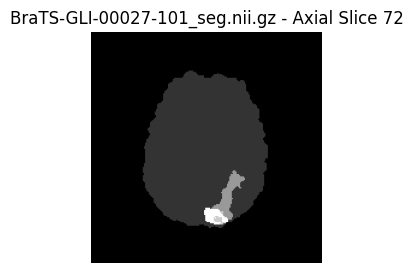

BraTS-GLI-00511-101_seg.nii.gz


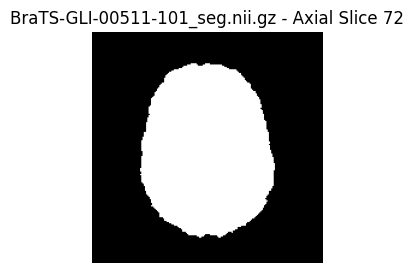

BraTS-GLI-00517-100_seg.nii.gz


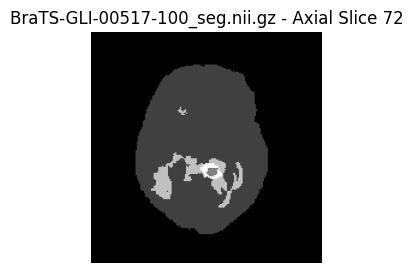

BraTS-GLI-00529-101_seg.nii.gz


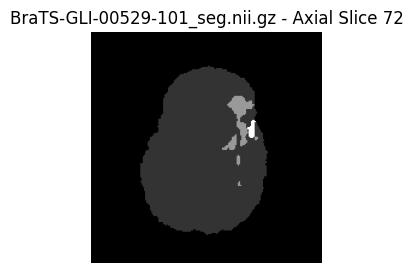

BraTS-GLI-00543-101_seg.nii.gz


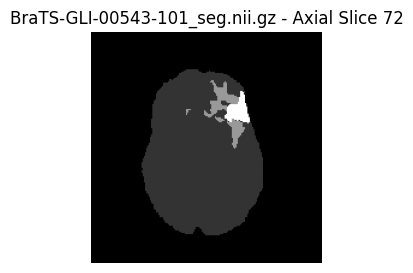

BraTS-GLI-02062-104_seg.nii.gz


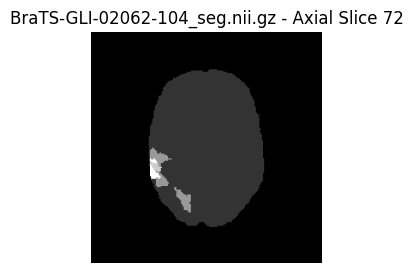

BraTS-GLI-02087-100_seg.nii.gz


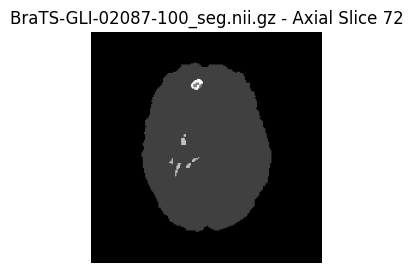

BraTS-GLI-02092-105_seg.nii.gz


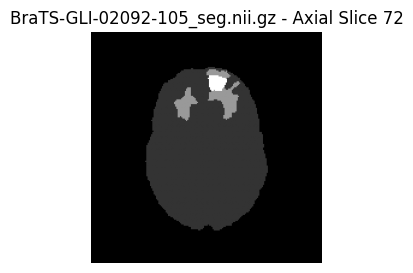

BraTS-GLI-02096-100_seg.nii.gz


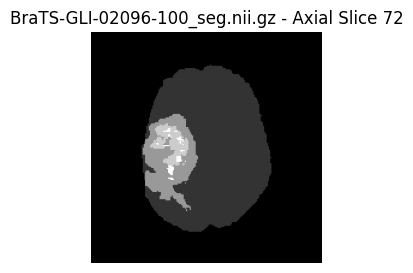

BraTS-GLI-02096-102_seg.nii.gz


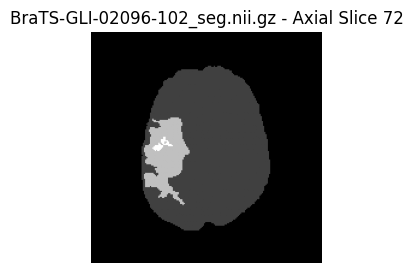

BraTS-GLI-02101-101_seg.nii.gz


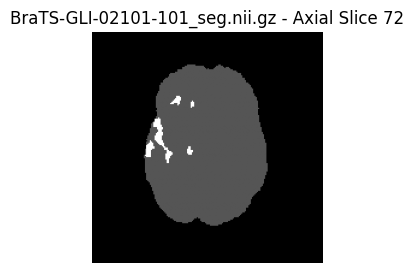

BraTS-GLI-02104-101_seg.nii.gz


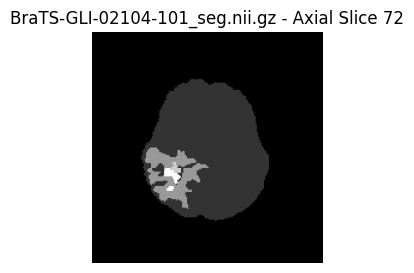

BraTS-GLI-02111-103_seg.nii.gz


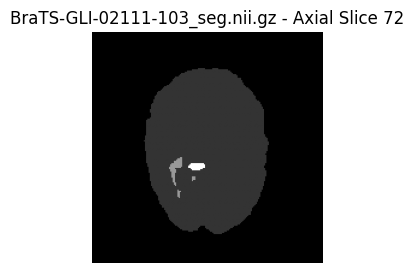

BraTS-GLI-02124-101_seg.nii.gz


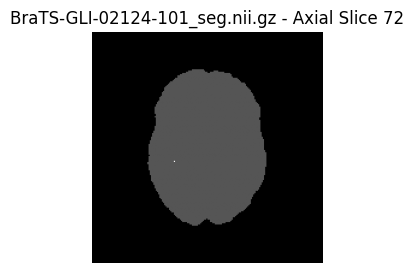

BraTS-GLI-02137-103_seg.nii.gz


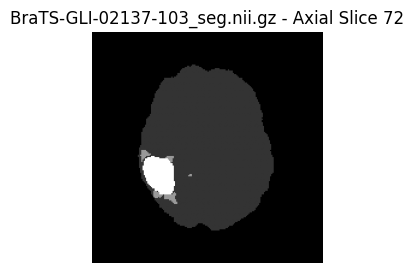

BraTS-GLI-02152-101_seg.nii.gz


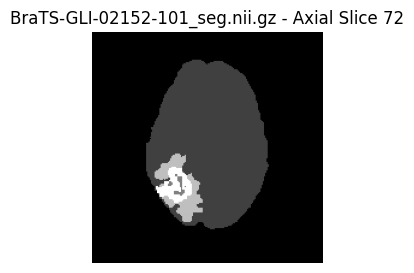

BraTS-GLI-02154-100_seg.nii.gz


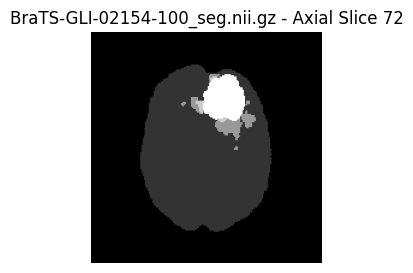

BraTS-GLI-02194-106_seg.nii.gz


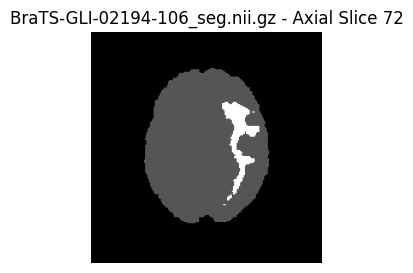

BraTS-GLI-02205-105_seg.nii.gz


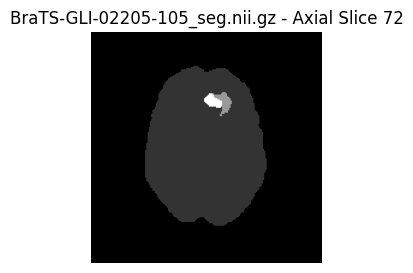

BraTS-GLI-02207-101_seg.nii.gz


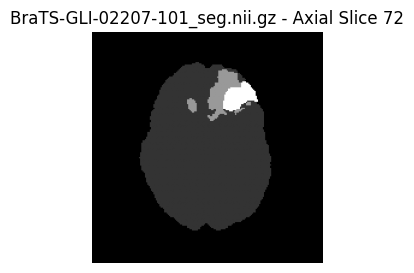

BraTS-GLI-02209-100_seg.nii.gz


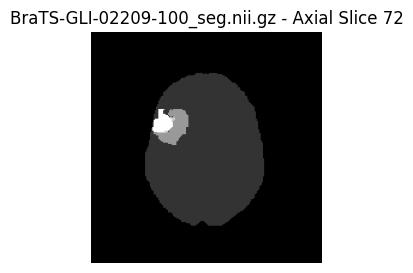

BraTS-GLI-02215-100_seg.nii.gz


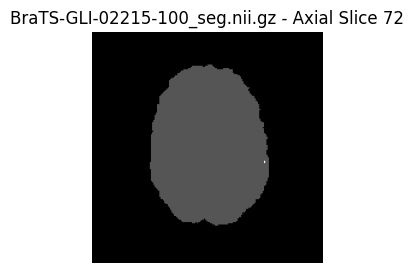

BraTS-GLI-02219-100_seg.nii.gz


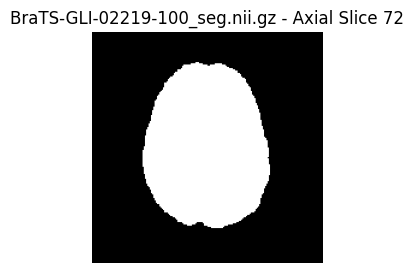

BraTS-GLI-02236-100_seg.nii.gz


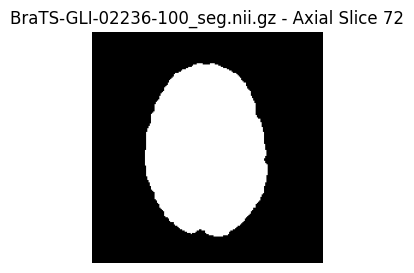

BraTS-GLI-02247-101_seg.nii.gz


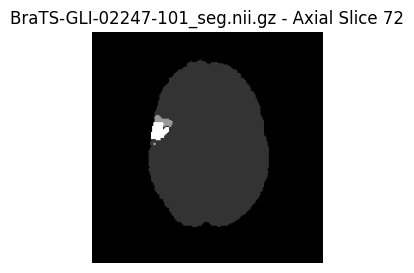

BraTS-GLI-02267-100_seg.nii.gz


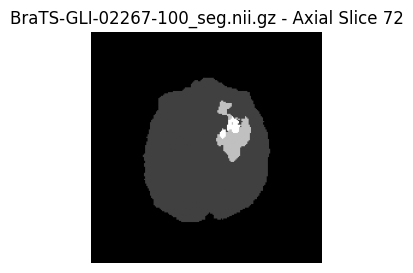

BraTS-GLI-02270-100_seg.nii.gz


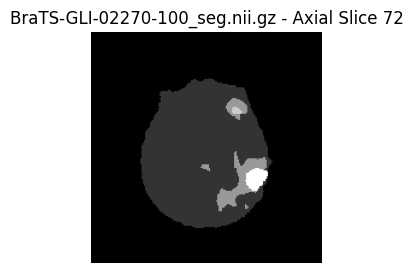

BraTS-GLI-02520-104_seg.nii.gz


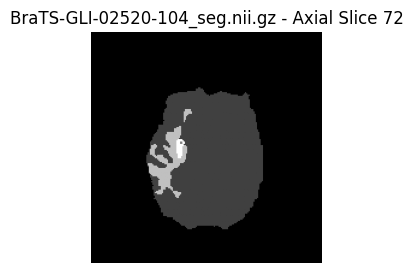

BraTS-GLI-02531-100_seg.nii.gz


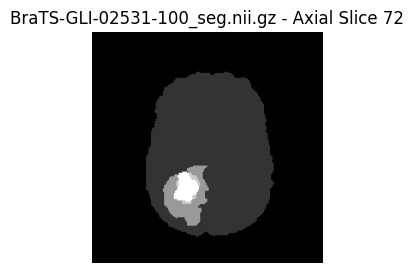

BraTS-GLI-02549-100_seg.nii.gz


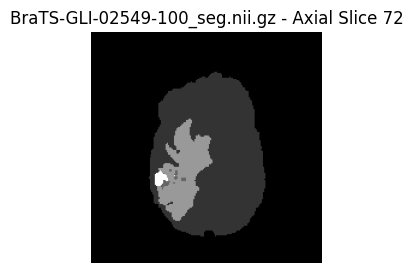

BraTS-GLI-02610-102_seg.nii.gz


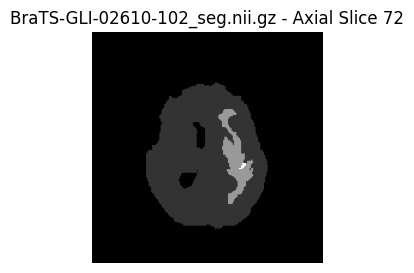

BraTS-GLI-02665-100_seg.nii.gz


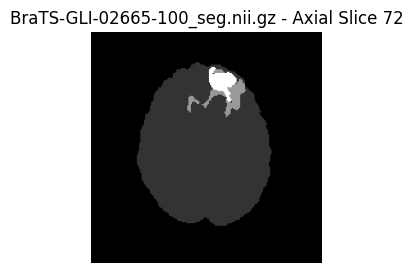

BraTS-GLI-02685-100_seg.nii.gz


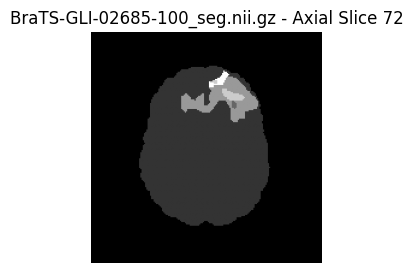

BraTS-GLI-02767-100_seg.nii.gz


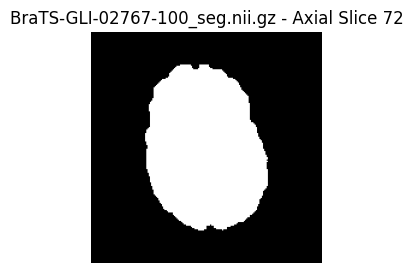

BraTS-GLI-02769-101_seg.nii.gz


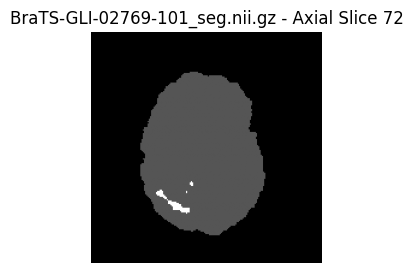

BraTS-GLI-02770-100_seg.nii.gz


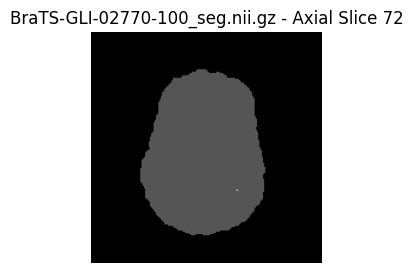

BraTS-GLI-02800-100_seg.nii.gz


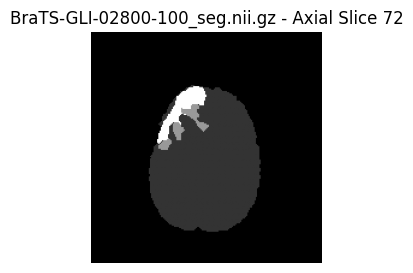

BraTS-GLI-02813-101_seg.nii.gz


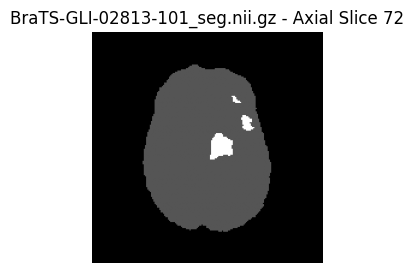

BraTS-GLI-02866-101_seg.nii.gz


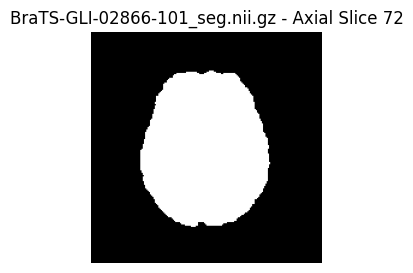

BraTS-GLI-02898-101_seg.nii.gz


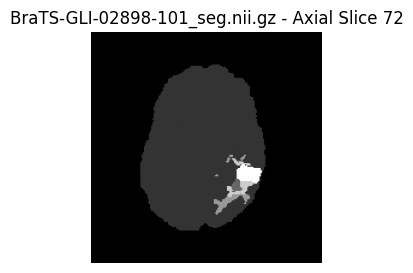

BraTS-GLI-02909-101_seg.nii.gz


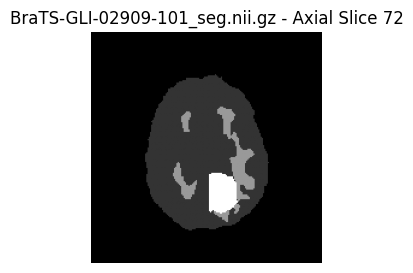

BraTS-GLI-02927-100_seg.nii.gz


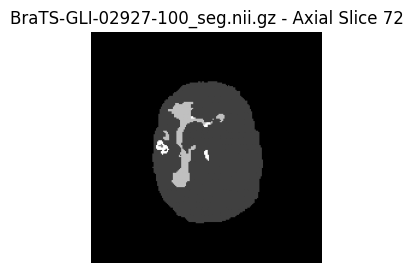

BraTS-GLI-02961-101_seg.nii.gz


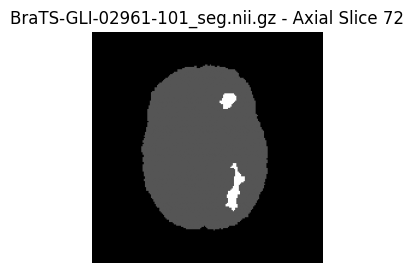

BraTS-GLI-02965-100_seg.nii.gz


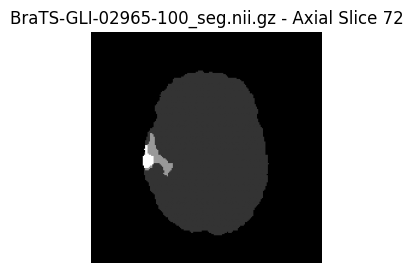

BraTS-GLI-02981-101_seg.nii.gz


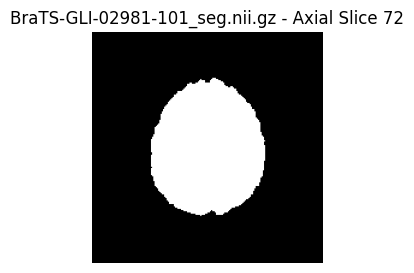

BraTS-GLI-02983-101_seg.nii.gz


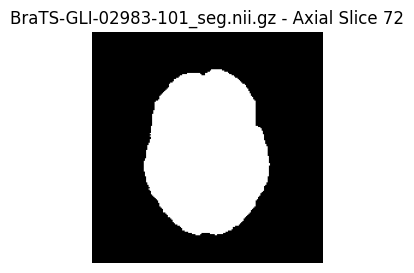

BraTS-GLI-03028-100_seg.nii.gz


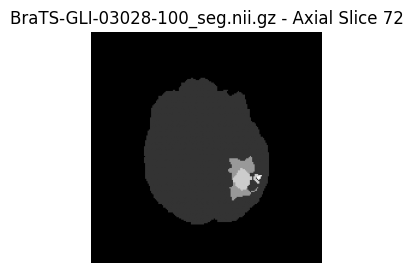

BraTS-GLI-03050-101_seg.nii.gz


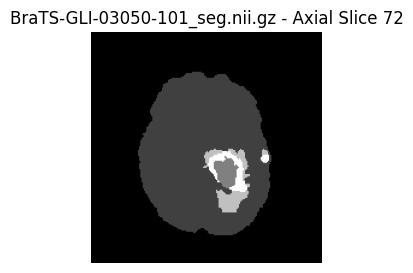

BraTS-GLI-03060-100_seg.nii.gz


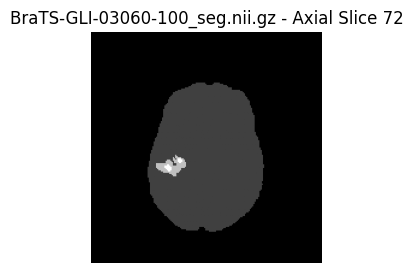

BraTS-GLI-03060-101_seg.nii.gz


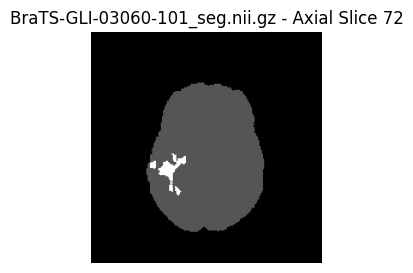

In [13]:
!pip install matplotlib
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Define the path to your NIfTI files directory
nifti_folder = os.path.join(config["dataset"]["output_root"], 'val_seg')

# Verify that the directory exists
if not os.path.isdir(nifti_folder):
    raise NotADirectoryError(f"The specified folder does not exist: {nifti_folder}")

# Retrieve all .nii and .nii.gz files in the directory
nifti_files = sorted(glob(os.path.join(nifti_folder, '*.nii')) + 
                    glob(os.path.join(nifti_folder, '*.nii.gz')))

# Check if any NIfTI files are found
if not nifti_files:
    raise FileNotFoundError(f"No NIfTI files found in the directory: {nifti_folder}")

print(f"Found {len(nifti_files)} NIfTI files in '{nifti_folder}'.")

def plot_middle_slice(nifti_path, plane='axial', figsize=(3,3)):
    """
    Loads a NIfTI file, extracts the middle slice from the specified plane, and plots it.
    
    Parameters:
    - nifti_path (str): Path to the NIfTI file.
    - plane (str): Anatomical plane to extract the slice from ('axial', 'sagittal', 'coronal').
    - figsize (tuple): Size of the matplotlib figure.
    """
    try:
        # Load the NIfTI file
        img = nib.load(nifti_path)
        data = img.get_fdata()
        
        # Determine the middle slice index based on the plane
        if plane == 'axial':
            slice_idx = data.shape[2] // 2
            slice_data = data[:, :, slice_idx]
            xlabel, ylabel = 'X-axis', 'Y-axis'
        elif plane == 'sagittal':
            slice_idx = data.shape[0] // 2
            slice_data = data[slice_idx, :, :]
            xlabel, ylabel = 'Y-axis', 'Z-axis'
        elif plane == 'coronal':
            slice_idx = data.shape[1] // 2
            slice_data = data[:, slice_idx, :]
            xlabel, ylabel = 'X-axis', 'Z-axis'
        else:
            raise ValueError("Invalid plane. Choose from 'axial', 'sagittal', or 'coronal'.")
        
        # Plot the slice
        print(f"{os.path.basename(nifti_path)}")
        plt.figure(figsize=figsize)
        plt.imshow(np.rot90(slice_data), cmap='gray')  # Rotate for correct orientation
        plt.title(f"{os.path.basename(nifti_path)} - {plane.capitalize()} Slice {slice_idx}")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error processing {nifti_path}: {e}")

# Choose the anatomical plane: 'axial', 'sagittal', or 'coronal'
chosen_plane = 'axial'  # Change to 'sagittal' or 'coronal' as needed

for nifti_file in nifti_files:
    plot_middle_slice(nifti_file, plane=chosen_plane)

The modified BraTS 2024 Adult Post-Treatment Glioma dataset contains segmentation masks with missing parts of the head, so the following samples were removed. Note that these may change depending on your dataset. They also might change if this script is reran, so always verify the entire dataset before training GliomaGen.

### Removed Training Samples

- BraTS-GLI-00046-100_seg.nii.gz
- BraTS-GLI-00060-101_seg.nii.gz
- BraTS-GLI-00060-100_seg.nii.gz
- BraTS-GLI-02086-101_seg.nii.gz
- BraTS-GLI-02086-100_seg.nii.gz
- BraTS-GLI-02088-101_seg.nii.gz
- BraTS-GLI-02088-102_seg.nii.gz
- BraTS-GLI-02103-105_seg.nii.gz
- BraTS-GLI-02106-100_seg.nii.gz
- BraTS-GLI-02106-102_seg.nii.gz
- BraTS-GLI-02106-101_seg.nii.gz
- BraTS-GLI-02110-101_seg.nii.gz
- BraTS-GLI-02116-100_seg.nii.gz
- BraTS-GLI-02116-101_seg.nii.gz
- BraTS-GLI-02118-101_seg.nii.gz
- BraTS-GLI-02120-100_seg.nii.gz
- BraTS-GLI-02120-101_seg.nii.gz
- BraTS-GLI-02129-100_seg.nii.gz
- BraTS-GLI-02129-101_seg.nii.gz
- BraTS-GLI-02129-103_seg.nii.gz
- BraTS-GLI-02129-104_seg.nii.gz
- BraTS-GLI-02129-102_seg.nii.gz
- BraTS-GLI-02135-101_seg.nii.gz
- BraTS-GLI-02141-100_seg.nii.gz
- BraTS-GLI-02141-101_seg.nii.gz
- BraTS-GLI-02146-100_seg.nii.gz
- BraTS-GLI-02146-101_seg.nii.gz
- BraTS-GLI-02146-102_seg.nii.gz
- BraTS-GLI-02146-103_seg.nii.gz
- BraTS-GLI-02152-104_seg.nii.gz
- BraTS-GLI-02152-102_seg.nii.gz
- BraTS-GLI-02157-101_seg.nii.gz
- BraTS-GLI-02157-100_seg.nii.gz
- BraTS-GLI-02158-100_seg.nii.gz
- BraTS-GLI-02170-102_seg.nii.gz
- BraTS-GLI-02170-101_seg.nii.gz
- BraTS-GLI-02175-101_seg.nii.gz
- BraTS-GLI-02175-100_seg.nii.gz
- BraTS-GLI-02175-102_seg.nii.gz
- BraTS-GLI-02192-102_seg.nii.gz
- BraTS-GLI-02217-100_seg.nii.gz
- BraTS-GLI-02221-100_seg.nii.gz
- BraTS-GLI-02221-103_seg.nii.gz
- BraTS-GLI-02228-100_seg.nii.gz
- BraTS-GLI-02237-102_seg.nii.gz
- BraTS-GLI-02240-100_seg.nii.gz
- BraTS-GLI-02498-100_seg.nii.gz
- BraTS-GLI-02514-104_seg.nii.gz
- BraTS-GLI-02556-100_seg.nii.gz
- BraTS-GLI-02638-101_seg.nii.gz
- BraTS-GLI-02689-100_seg.nii.gz
- BraTS-GLI-02699-100_seg.nii.gz
- BraTS-GLI-02774-101_seg.nii.gz
- BraTS-GLI-02787-100_seg.nii.gz
- BraTS-GLI-02787-101_seg.nii.gz
- BraTS-GLI-02792-101_seg.nii.gz
- BraTS-GLI-02793-100_seg.nii.gz
- BraTS-GLI-02793-101_seg.nii.gz
- BraTS-GLI-02794-100_seg.nii.gz
- BraTS-GLI-02857-100_seg.nii.gz
- BraTS-GLI-02890-101_seg.nii.gz
- BraTS-GLI-02922-100_seg.nii.gz
- BraTS-GLI-02955-100_seg.nii.gz
- BraTS-GLI-02961-100_seg.nii.gz
- BraTS-GLI-02969-100_seg.nii.gz

### Removed Validation Samples 
- BraTS-GLI-02205-105_seg.nii.gz
- BraTS-GLI-02769-101_seg.nii.gz
